In [1]:
# !pip uninstall tensorflow
# !pip install tensorflow==2.12.1

^C


In [ ]:
# !unzip "dataset_v6.zip"

Archive:  dataset_v6.zip
   creating: dataset_v6/
   creating: dataset_v6/test/
   creating: dataset_v6/test/boat/
  inflating: dataset_v6/test/boat/20201016_120407_image_mel_spec_segment_97.png  
  inflating: dataset_v6/test/boat/20201016_120407_image_mel_spec_segment_99.png  
  inflating: dataset_v6/test/boat/20201016_233700_image_mel_spec_segment_154.png  
  inflating: dataset_v6/test/boat/20201016_233700_image_mel_spec_segment_157.png  
  inflating: dataset_v6/test/boat/20201016_233700_image_mel_spec_segment_171.png  
  inflating: dataset_v6/test/boat/20201016_233700_image_mel_spec_segment_175.png  
  inflating: dataset_v6/test/boat/20201017_011137_image_mel_spec_segment_186.png  
  inflating: dataset_v6/test/boat/20201017_011137_image_mel_spec_segment_84.png  
  inflating: dataset_v6/test/boat/20201017_123457_image_mel_spec_segment_80.png  
  inflating: dataset_v6/test/boat/20201017_123457_image_mel_spec_segment_83.png  
  inflating: dataset_v6/test/boat/20201017_221700_image_mel_

dataset_v7: copy the whale data twice

In [1]:
import tensorflow as tf

print('tensorflow version = ', tf.__version__)

tensorflow version =  2.12.1


In [2]:
tf.config.list_physical_devices('GPU')

[]

In [3]:
# Define relevant variables for the ML task
image_size = (64, 64)
input_shape = (64, 64, 3)
batch_size = 8
num_classes = 4
learning_rate = 0.0001
num_epochs = 150

In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# 字典對應表
dict_for_label = {
    'boat': [1, 0, 0, 0], 'dolphin': [0, 1, 0, 0], 'fish': [0, 0, 1, 0], 'whale': [0, 0, 0, 1],
    'boat+fish': [1, 0, 1, 0], 'boat+whale': [1, 0, 0, 1],
    'dolphin+boat': [1, 1, 0, 0], 'dolphin+whale': [0, 1, 0, 1], 'dolphin+fish': [0, 1, 1, 0],
    'fish+whale': [0, 0, 1, 1]
}

# 自訂多標籤資料集
class MultiLabelImageDataset(tf.keras.utils.Sequence):
    def __init__(self, image_folder, label_mapping, target_size=(224, 224), batch_size=32):
        """
        初始化資料集
        :param image_folder: 圖片資料夾的路徑
        :param label_mapping: 標籤字典
        :param target_size: 圖片調整大小
        :param batch_size: 每批的大小
        """
        self.image_folder = image_folder
        self.label_mapping = label_mapping
        self.target_size = target_size
        self.batch_size = batch_size

        # 掃描資料夾內的所有圖片
        self.image_paths = []
        self.labels = []
        for class_name, one_hot in label_mapping.items():
            class_folder = os.path.join(image_folder, class_name) # find specific folder
            if os.path.exists(class_folder):
                for file_name in os.listdir(class_folder):
                    if file_name.endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(os.path.join(class_folder, file_name))
                        self.labels.append(one_hot)

        # 將資料轉換為 numpy 陣列
        self.image_paths = np.array(self.image_paths)
        self.labels = np.array(self.labels, dtype=np.float32)

    def __len__(self):
        """定義每個 epoch 包含的批次數"""
        return len(self.image_paths) // batch_size # self.batch_size

    def __getitem__(self, idx):
        """獲取一批資料"""
        # list slicing
        batch_images = self.image_paths[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size : (idx + 1) * self.batch_size]

        images = []
        for image_path in batch_images:
            # 加載圖片並調整大小
            img = load_img(image_path, target_size=self.target_size)
            img_array = img_to_array(img) / 255.0  # 標準化到 [0, 1]
            images.append(img_array)

        return np.array(images), np.array(batch_labels)


In [5]:
# 使用自定義的多標籤資料集
source_folder = "dataset_v7/train"
test_folder = "dataset_v7/test"

def load_dataset(image_folder, label_mapping, target_size, batch_size):
    # 創建資料集實例
    dataset = MultiLabelImageDataset(
        image_folder=image_folder,
        label_mapping=dict_for_label,
        target_size=image_size,
        batch_size=batch_size
    )

    # 將資料集轉換為 TensorFlow Dataset 格式
    def generator():
        for i in range(len(dataset)):
            images, labels = dataset[i]  # 確保 dataset[i] 返回的是單張圖片和對應標籤
            for j in range(len(images)):
                yield images[j], labels[j]

    # TensorFlow Dataset API
    tf_dataset = tf.data.Dataset.from_generator(
        generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=(
            (image_size[0], image_size[1], 3),  # Image shape: (height, width, channels)
            (len(dict_for_label["boat"]),)       # Label shape: (num_classes,)
        )
    )

    # 打亂資料集並分批次
    tf_dataset = tf_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(1)
    return tf_dataset

train_dataset = load_dataset(source_folder, dict_for_label, image_size, batch_size)
test_dataset = load_dataset(test_folder, dict_for_label, image_size, batch_size)

# 測試加載資料
for images, labels in train_dataset.take(1):  # 取第一個批次
    print("Images shape:", images.shape)  # (batch_size, height, width, channels)
    print("Labels shape:", labels.shape)  # (batch_size, num_classes)
    print("First label:", labels[0].numpy())  # 查看第一張圖片的標籤
    break

Images shape: (8, 64, 64, 3)
Labels shape: (8, 4)
First label: [0. 1. 0. 0.]


Create model

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import L2

# 使用 Sequential 定義模型
model = models.Sequential()

# Layer 1
model.add(layers.Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=(64, 64, 3)))
#model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Layer 2
model.add(layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
#model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Layer 3
model.add(layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
#model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Layer 4
model.add(layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
#model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Layer 5
model.add(layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
#model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Flatten Layer
model.add(layers.Flatten())

# Fully Connected Layer
model.add(layers.Dense(4))

# 檢查模型結構
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 64)         0

In [7]:
import random
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# 優化器與損失函數
optimizer = Adam(learning_rate=learning_rate)
lossFunc = BinaryCrossentropy(from_logits=True)

# 編譯模型
model.compile(optimizer=optimizer, loss=lossFunc, metrics=['binary_accuracy'])

# 設置檢查點回調，儲存最佳模型權重
checkpoint1 = ModelCheckpoint(filepath="TFModel_best_acc.h5", save_weights_only=True, save_best_only=True, monitor='val_binary_accuracy', mode='max', verbose=0)
checkpoint2 = ModelCheckpoint(filepath="TFModel_best_loss.h5", save_weights_only=True, save_best_only=True, monitor='val_loss', mode='min', verbose=0)

# early_stop
callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0,
    patience=30, verbose=0, mode='min',
    restore_best_weights=True
)

# 開始訓練
history = model.fit(train_dataset,  # 訓練資料集
                    epochs=num_epochs,
                    validation_data=test_dataset,  # 驗證資料集
                    callbacks=[checkpoint1, checkpoint2])  # 添加檢查點回調

model.save_weights('TFModel.h5')

Epoch 1/150
70/70 [==============================] - 14s 109ms/step - loss: 0.6603 - binary_accuracy: 0.6536 - val_loss: 0.6418 - val_binary_accuracy: 0.6477
Epoch 2/150
70/70 [==============================] - 4s 38ms/step - loss: 0.6347 - binary_accuracy: 0.6536 - val_loss: 0.6275 - val_binary_accuracy: 0.6477
Epoch 3/150
70/70 [==============================] - 4s 38ms/step - loss: 0.6150 - binary_accuracy: 0.6536 - val_loss: 0.6009 - val_binary_accuracy: 0.6477
Epoch 4/150
70/70 [==============================] - 4s 39ms/step - loss: 0.5744 - binary_accuracy: 0.6585 - val_loss: 0.5689 - val_binary_accuracy: 0.6534
Epoch 5/150
70/70 [==============================] - 3s 36ms/step - loss: 0.5299 - binary_accuracy: 0.7094 - val_loss: 0.5135 - val_binary_accuracy: 0.7528
Epoch 6/150
70/70 [==============================] - 4s 38ms/step - loss: 0.4951 - binary_accuracy: 0.7567 - val_loss: 0.4758 - val_binary_accuracy: 0.8011
Epoch 7/150
70/70 [==============================] - 4s 41ms/s

Best Epoch: 145, Best Validation Accuracy: 0.9261
Best Epoch: 137, Best Loss: 0.2165


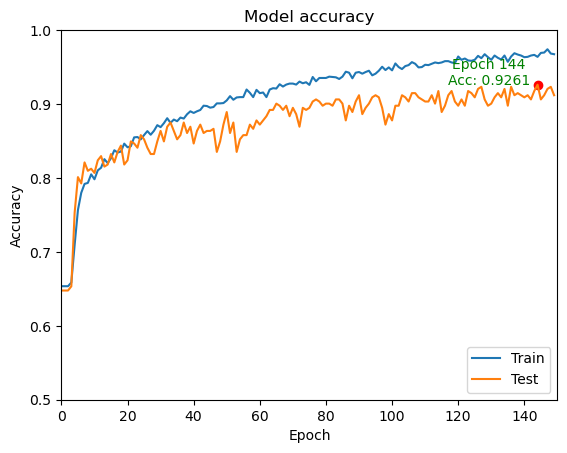

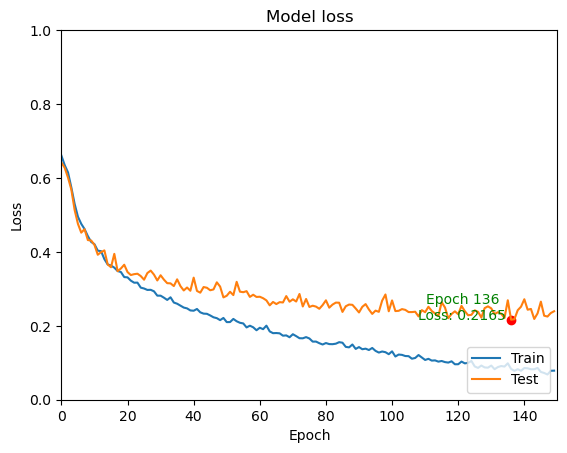

In [8]:
import matplotlib.pyplot as plt

# 找到最佳驗證準確率及其對應的 Epoch
best_acc_epoch = np.argmax(history.history['val_binary_accuracy'])
best_loss_epoch = np.argmin(history.history['val_loss'])
best_val_acc = max(history.history['val_binary_accuracy'])
best_val_loss = min(history.history['val_loss'])

print(f"Best Epoch: {best_acc_epoch + 1}, Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Best Epoch: {best_loss_epoch + 1}, Best Loss: {best_val_loss:.4f}")

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim([0, num_epochs])
plt.ylim([0.5, 1])
plt.legend(['Train', 'Test'], loc='lower right')
# 標註最終儲存的點
plt.scatter(best_acc_epoch, best_val_acc, color='red')
plt.annotate(f'Epoch {best_acc_epoch}\nAcc: {best_val_acc:.4f}', (best_acc_epoch, best_val_acc), textcoords="offset points", xytext=(-35, 0), ha='center', color='green')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim([0, num_epochs])
plt.ylim([0, 1])
plt.legend(['Train', 'Test'], loc='lower right')
# 標註最終儲存的點
plt.scatter(best_loss_epoch, best_val_loss, color='red')
plt.annotate(f'Epoch {best_loss_epoch}\nLoss: {best_val_loss:.4f}', (best_loss_epoch, best_val_loss), textcoords="offset points", xytext=(-35, 0), ha='center', color='green')
plt.show()

Save json file

In [9]:
# 儲存模型架構
model_json = model.to_json()
with open("tf_model_structure.json", "w") as json_file:
    json_file.write(model_json)

預測資料

load h5 to model

In [10]:
model.load_weights('TFModel.h5', by_name=True)

test_loss, test_acc = model.evaluate(test_dataset, verbose=1)
print('test accuracy = ', test_acc)

11/11 [==============================] - 0s 21ms/step - loss: 0.2394 - binary_accuracy: 0.9119
test accuracy =  0.9119318127632141


In [11]:
test_input = tf.random.normal([1, 64, 64, 3])
output = model(test_input)
print("Model output:", output)

Model output: tf.Tensor([[-46.25037  -32.255383  31.61797  -75.36327 ]], shape=(1, 4), dtype=float32)


Predict data like pytorch way

In [12]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score

# 初始化預測數據
pred_list = []
label_list = []

# 預測模型
for images, labels in test_dataset:
    # 預測輸出 (模型的 output 是 (batch_size, num_classes))
    outputs = model(images, training=False)
    # print(outputs)

    # 計算每個類別的預測概率（Sigmoid 函數處理）
    predicted_prob = tf.sigmoid(outputs)
    # print(predicted_prob)

    # 將每個類別的預測概率與閾值 0.5 比較，大於 0.5 表示該類別存在 (標記為 1)
    predicted = tf.cast(outputs > 0.5, tf.int32)
    # print(predicted)

    # 將預測和真實標籤加入列表
    pred_list.extend(predicted.numpy())
    label_list.extend(labels.numpy())

In [ ]:
# 改為 numpy 陣列，便於計算
pred_list = np.array(pred_list)
label_list = np.array(label_list)

# 計算整體準確度
accuracy = accuracy_score(label_list, pred_list)
print(f'Subset Accuracy of the network on the test images: {accuracy * 100:.2f} %')

# 自定義的準確度函數
def Accuracy(y_pred, y_true):
    count = 0
    for i in range(y_true.shape[0]):  # 幾個樣本
        p = np.sum(np.logical_and(y_pred[i], y_true[i]))
        q = np.sum(np.logical_or(y_pred[i], y_true[i]))
        count += p / q
    return count / y_true.shape[0]

print(f'Accuracy of the network on the test images: {Accuracy(pred_list, label_list) * 100:.2f} %')

Subset Accuracy of the network on the test images: 64.77 %
Accuracy of the network on the test images: 80.87 %


In [13]:
# precision, recall, f1-score
from sklearn.metrics import precision_score, recall_score, f1_score

print(f'Precision: {precision_score(label_list, pred_list, average="samples")}')
print(f'Recall: {recall_score(label_list, pred_list, average="samples")}')
print(f'F1-score: {f1_score(label_list, pred_list, average="samples")}')

Precision: 0.899621212121212
Recall: 0.8636363636363636
F1-score: 0.8632575757575758


d:\ancode\envs\cpu-tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


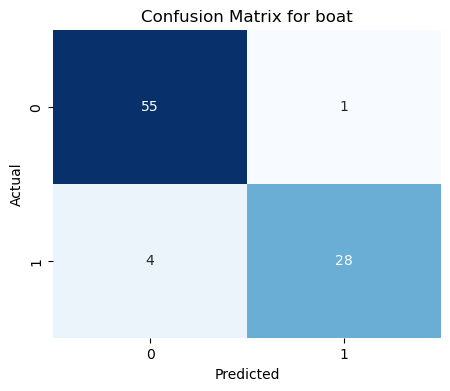

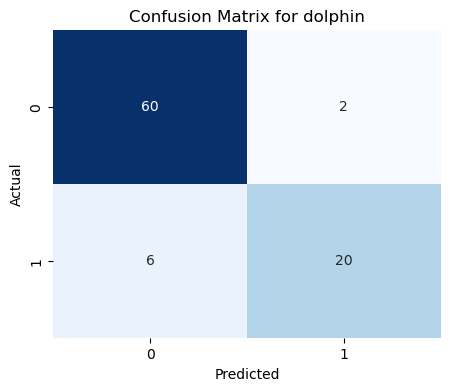

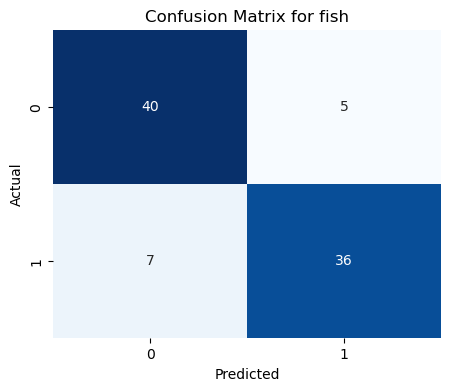

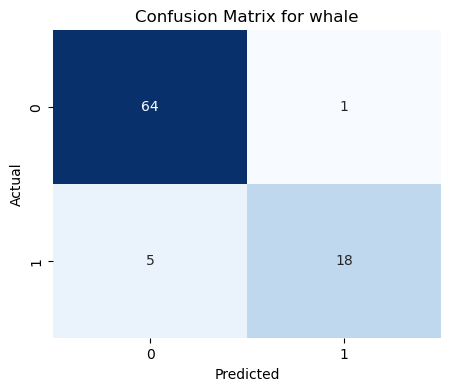

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

pred_list = np.array(pred_list)
label_list = np.array(label_list)

for i , class_name in enumerate(dict_for_label.keys()):
    if i >= num_classes:
        break

    cm = confusion_matrix(label_list[:, i], pred_list[:, i])

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {class_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


In [15]:
from sklearn.metrics import hamming_loss

# 計算 Hamming Loss
hloss = hamming_loss(label_list, pred_list)
print(f"Hamming Loss: {hloss}")

Hamming Loss: 0.08806818181818182


Test on recording data  

In [20]:
img_path = "dataset_v7/test_record/"
rc_test_dataset = load_dataset(img_path, dict_for_label, image_size, batch_size)

# 初始化預測數據
rc_pred_list = []
rc_label_list = []

# 預測模型
for images, labels in rc_test_dataset:
    # 預測輸出 (模型的 output 是 (batch_size, num_classes))
    outputs = model(images, training=False)
    # print(outputs)

    # 計算每個類別的預測概率（Sigmoid 函數處理）
    predicted_prob = tf.sigmoid(outputs)
    # print(predicted_prob)

    # 將每個類別的預測概率與閾值 0.5 比較，大於 0.5 表示該類別存在 (標記為 1)
    predicted = tf.cast(outputs > 0.5, tf.int32)
    print(f'True label:{labels} Predicted label:{predicted}')

    # 將預測和真實標籤加入列表
    rc_pred_list.extend(predicted.numpy())
    rc_label_list.extend(labels.numpy())

True label:[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]] Predicted label:[[0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]]
True label:[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]] Predicted label:[[0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]]
True label:[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]] Predicted label:[[0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]]
True label:[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]] Predicted label:[[0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]]
True label:[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 

In [21]:
# precision, recall, f1-score
from sklearn.metrics import precision_score, recall_score, f1_score
# 計算整體準確度
accuracy = accuracy_score(rc_label_list, rc_pred_list)
print(f'Subset Accuracy of the network on the test images: {accuracy * 100:.2f} %')
print(f'Precision: {precision_score(rc_label_list, rc_pred_list, average="samples")}')
print(f'Recall: {recall_score(rc_label_list, rc_pred_list, average="samples")}')
print(f'F1-score: {f1_score(rc_label_list, rc_pred_list, average="samples")}')

Subset Accuracy of the network on the test images: 100.00 %
Precision: 1.0
Recall: 1.0
F1-score: 1.0
